# Tools and ReAct Agents


This notebook covers tool integration and the ReAct pattern at three levels of abstraction:
1. **LangChain 1.0** — `create_agent` with middleware support (preview)
2. **Manual** — build ReAct from scratch with `StateGraph`

Plus: MCP (Model Context Protocol) integration for external tools.

In [14]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

## 1. Defining tools

Tools are functions the LLM can call. We use the `@tool` decorator to register them with a name, description, and typed arguments. The LLM sees the description and decides when/how to call each tool.

In [ ]:
from langchain_core.tools import tool
# StructuredTool is another option
from langchain_community.utilities import SerpAPIWrapper


@tool
def calculator(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"


@tool
def get_current_date() -> str:
    """Get today's date. Use this when the user asks about today or the current date."""
    from datetime import date
    return str(date.today())


@tool
def web_search(query: str) -> str:
    """Search the web for real-time information. Use this for current events, facts, or any question requiring up-to-date knowledge."""
    serpapi = SerpAPIWrapper()
    return serpapi.run(query)
    # optionally, I could parse the result and return something different


tools = [calculator, get_current_date, web_search]

# Each tool has a name and description the LLM can read
for t in tools:
    print(f"{t.name}: {t.description[:80]}")

calculator: Evaluate a mathematical expression. Use this for any math calculations.
get_current_date: Get today's date. Use this when the user asks about today or the current date.
web_search: Search the web for real-time information. Use this for current events, facts, or


## 2. Prebuilt ReAct agent (`create_agent`)

The fastest way to get a tool-calling agent running. Under the hood, this creates a `StateGraph` with two nodes ("agent" and "tools") and a conditional edge that loops until the LLM stops calling tools.

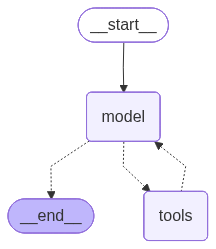

In [27]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

llm = ChatOpenAI(
    model="allenai/olmo-3.1-32b-instruct",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

agent = create_agent(llm, tools)

# Visualize — two nodes: agent (LLM) and tools (executor)
display(Image(agent.get_graph().draw_mermaid_png()))

In [28]:
# Test: requires calculator tool
result = agent.invoke({"messages": [("user", "What is 247 * 38?")]})

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 247 * 38?
================================== Ai Message ==================================
Tool Calls:
  calculator (chatcmpl-tool-a12c261b7c53b19a)
 Call ID: chatcmpl-tool-a12c261b7c53b19a
  Args:
    expression: 247 * 38
================================= Tool Message =================================
Name: calculator

9386
================================== Ai Message ==================================

247 multiplied by 38 equals 9,386.


In [33]:
result["messages"][3]

AIMessage(content='247 multiplied by 38 equals 9,386.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 323, 'total_tokens': 335, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'cost': 7.1082e-05, 'is_byok': False, 'cost_details': {'upstream_inference_cost': 7.18e-05, 'upstream_inference_prompt_cost': 6.46e-05, 'upstream_inference_completions_cost': 7.2e-06}}, 'model_provider': 'openai', 'model_name': 'allenai/olmo-3.1-32b-instruct', 'system_fingerprint': None, 'id': 'gen-1771440394-zFrbK0Y1xeIWzYojbPdP', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c7213-52e9-7571-886d-830a5653a11d-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 323, 'output_tokens': 12, 'total_tokens': 335, 'input_token_details': {'audio': 0, 'cache_re

In [18]:
# Test: requires search tool
result = agent.invoke({"messages": [("user", "What was the latest LangChain release?")]})

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What was the latest LangChain release?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_zXI0rwlqql8bInDOkMfmUsHE)
 Call ID: call_zXI0rwlqql8bInDOkMfmUsHE
  Args:
    query: latest LangChain release
================================= Tool Message =================================
Name: web_search

['LangChain 1.1. LangChain v1.1.0 is now available This release makes agent development more reliable, more structured, and more context-aware — powered by a new.', 'Changes since langchain==1.2.9. release(langchain): 1.2.10 (#35137) chore(deps): bump the langchain-deps group across 3 directories with 40 updates (#35129)', 'langchain v1.2.0. create_agent : Simplified support for provider-specific tool parameters and definitions via a new extras attribute on tools. Examples:.', 'When we refer to a minor version, such as v0.3, we always mean its latest a

In [19]:
# Test: requires date tool + search
result = agent.invoke({"messages": [("user", "What's today's date, and what happened in AI news today?")]})

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What's today's date, and what happened in AI news today?
================================== Ai Message ==================================
Tool Calls:
  get_current_date (call_VNeyhXjuxEBcVA31AxIsqTLL)
 Call ID: call_VNeyhXjuxEBcVA31AxIsqTLL
  Args:
  web_search (call_8QuGC2YJS2212ZKDZ72UUhVC)
 Call ID: call_8QuGC2YJS2212ZKDZ72UUhVC
  Args:
    query: AI news today
================================= Tool Message =================================
Name: get_current_date

2026-02-18
================================= Tool Message =================================
Name: web_search

[{"title": "Stock market today: Dow, S&P 500, Nasdaq futures rise as AI worries recede, with Fed minutes ahead", "link": "https://uk.finance.yahoo.com/news/stock-market-today-dow-sp-500-nasdaq-futures-rise-as-ai-worries-recede-with-fed-minutes-ahead-235322996.html", "source": "Yahoo Finance UK", "source_logo": "https://serpapi.com/sea

## 3. ReAct agent from scratch (manual StateGraph)

Understanding the internals is essential for customization. Let's build the same agent manually:
- `AgentState` with `add_messages` reducer
- `call_model` node — invokes the LLM with tool bindings
- `tool_node` — executes tool calls from the LLM's response
- `should_continue` — routes to tools or END based on whether the LLM made tool calls

In [20]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END, START


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


# Bind tools to the LLM so it knows what's available
llm_with_tools = llm.bind_tools(tools)

# Map tool names to tool objects for execution
tools_by_name = {t.name: t for t in tools}


def should_continue(state: AgentState) -> str:
    """If the last message has tool calls, route to tools. Otherwise, end."""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return "end"


def call_model(state: AgentState) -> dict:
    """Invoke the LLM with the current message history."""
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


def tool_node(state: AgentState) -> dict:
    """Execute each tool call from the last AI message."""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(content=str(result), tool_call_id=tool_call["id"])
        )
    return {"messages": outputs}


# Build the graph
graph = StateGraph(AgentState)
graph.add_node("agent", call_model)
graph.add_node("tools", tool_node)

graph.add_edge(START, "agent")
graph.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END},
)
graph.add_edge("tools", "agent")  # After tools run, go back to the LLM

manual_agent = graph.compile()

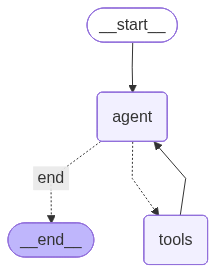

In [21]:
# The manual graph should look identical to the prebuilt one
display(Image(manual_agent.get_graph().draw_mermaid_png()))

In [22]:
# Test: same question, same result
result = manual_agent.invoke({"messages": [("user", "What is 247 * 38?")]})

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is 247 * 38?
================================== Ai Message ==================================
Tool Calls:
  calculator (call_HVGJ0uzTIjEytBQ0Zj9B87ji)
 Call ID: call_HVGJ0uzTIjEytBQ0Zj9B87ji
  Args:
    expression: 247 * 38
================================= Tool Message =================================

9386
================================== Ai Message ==================================

247 multiplied by 38 is 9,386.


The prebuilt and manual versions produce the same graph topology. The manual version gives you full control to customize the agent loop — add logging, modify tool results, inject system prompts, etc.

## 4. MCP integration

[Model Context Protocol (MCP)](https://modelcontextprotocol.io/) lets you load tools from external servers. The `langchain-mcp-adapters` package converts MCP tools into LangChain tools that work with any agent.

We have a custom MCP server in `mcp_server.py` with three tools: `add`, `multiply`, and `web_search`. Let's load it and combine those tools with our native tools.

In [23]:
import sys
from langchain_mcp_adapters.client import MultiServerMCPClient

# Point to our custom MCP server — it exposes add, multiply, and web_search tools
mcp_server_path = os.path.join(os.path.dirname(os.path.abspath("__file__")), "mcp_server.py")

client = MultiServerMCPClient(
    {
        "course_tools": {
            "command": sys.executable,  # Use the current Python interpreter
            "args": [mcp_server_path],
            "transport": "stdio",
        }
    }
)

In [24]:
# As of langchain-mcp-adapters 0.1.0, no context manager needed — just await get_tools()
mcp_tools = await client.get_tools()

print(f"Loaded {len(mcp_tools)} MCP tools:")
for t in mcp_tools:
    print(f"  {t.name}: {t.description[:60]}")

Loaded 3 MCP tools:
  add: Add two numbers together. Use this for addition calculations
  multiply: Multiply two numbers together. Use this for multiplication c
  web_search: Search the web for real-time information. Use this for any f


In [25]:
# Combine native tools (calculator, date) with MCP tools (add, multiply, web_search)
all_tools = [calculator, get_current_date] + mcp_tools
print(f"Total tools available: {len(all_tools)}")

# Build an agent with all tools
from langchain.agents import create_agent
combined_agent = create_agent(llm, all_tools)

# Test with MCP's add tool
print("\n--- Test: MCP add tool ---")
result = await combined_agent.ainvoke(
    {"messages": [("user", "Add 42 and 58 using the add tool")]}
)
for msg in result["messages"]:
    msg.pretty_print()

Total tools available: 5

--- Test: MCP add tool ---
================================ Human Message =================================

Add 42 and 58 using the add tool
================================== Ai Message ==================================
Tool Calls:
  add (call_BvbPbAPXs4xsjf83HBuY1k3o)
 Call ID: call_BvbPbAPXs4xsjf83HBuY1k3o
  Args:
    a: 42
    b: 58
================================= Tool Message =================================
Name: add

[{'type': 'text', 'text': '100', 'id': 'lc_a28ad7cc-e35a-4d57-be50-1664f361e636'}]
================================== Ai Message ==================================

The sum of 42 and 58 is 100.


In [26]:
# Test with MCP's multiply tool
print("--- Test: MCP multiply tool ---")
result = await combined_agent.ainvoke(
    {"messages": [("user", "Multiply 7 and 13")]}
)
for msg in result["messages"]:
    msg.pretty_print()

--- Test: MCP multiply tool ---
================================ Human Message =================================

Multiply 7 and 13
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7uicKyNOsvyBxq7kOwVSLEWs)
 Call ID: call_7uicKyNOsvyBxq7kOwVSLEWs
  Args:
    a: 7
    b: 13
================================= Tool Message =================================
Name: multiply

[{'type': 'text', 'text': '91', 'id': 'lc_c828a33e-a0b7-4393-9471-1c466954add9'}]
================================== Ai Message ==================================

7 multiplied by 13 equals 91.


The key insight: MCP tools are just LangChain tools once loaded. You can mix them freely with `@tool` functions, and the LLM treats them identically.

---

**Summary:**
- `@tool` decorator defines tools with typed arguments and descriptions
- `create_agent` (prebuilt) — fastest path to a working agent
- `create_agent` (LangChain 1.0) — same API, supports middleware (notebook 5)
- Manual `StateGraph` — full control over the agent loop
- MCP — load external tools from any MCP server

Next: we'll use tools inside a **RAG workflow** with conditional routing.